# 1. Module import and basic functions

## 1.1 Imports

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

import os
import random
import time

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import joblib

from sklearn.metrics import confusion_matrix
import seaborn as sn

## 1.2 Global variables

In [2]:
# Set the notebook name and derive the absolute path of the dataset
notebookName="FinalProject.ipynb"
datasetPath=os.path.abspath(notebookName)[0:-len(notebookName)]+"MWD/" #use absolute path

# Check if the MWD dataset folder exist
if not os.path.exists(datasetPath):
    raise FileNotFoundError("MWD dataset folder not found")


## 1.3 SVC/PCA fallbacks
Set ***use_pre_storedSVCPCA=1*** in the following block to use *"svc_weatherClassification.pkl"* and 
*"pca_weatherClassification.pkl"* instead of searching again for best parameters 
and fitting SVC/PCA.

This is meant as a fallback in the extreme case that running the notebook from scratch
does not provide a SVC with the same scores as in the report.

In [3]:
#fallback
use_pre_storedSVCPCA=0

## 1.4 Support functions

In [4]:
def show_img(image, title=None):
    # Code for following function was adapted from a previous Computer Vision lab
    """
    Display an image in the notebook.

    :param image: The image to be displayed.
    :param title: Optional title for the image.
    
    :return: None
    """
    # Check if the image is in BGR format and convert it to RGB
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    # Plot the image
    plt.figure() 
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()


def get_imagePaths_byWeather(datasetPath, 
                               datasetType="train",
                               weather_condition="cloudy"):
    """
    Get file paths for images that match a specific weather condition and dataset type.

    :param datasetPath: The base path of the MWD dataset.
    :param datasetType: Type of dataset, "train" or "test".
    :param weather_condition: The desired weather condition. Only one needs to be specified.
    
    :return: List of file paths matching the specified condition.
    """
    matching_files = [os.path.join(root, file) for root, dirs, files in os.walk(datasetPath+datasetType)
                     for file in files if weather_condition in file]
    imagePaths=[]
    for path in matching_files:
            imagePaths.append(path)
    return imagePaths

# 2. Functions for feature extraction

## 2.1 Normalization

In [5]:
def get_zNormalized_vector(vector):
    """
    Compute Z-score normalization for a vector.

    :param vector: Input vector.
    :return: Z-score normalized vector if std is not zero across dimensions, else the original vector.
    """
    mean = np.mean(vector)
    std = np.std(vector)
    if std !=0 :#in this case normalization is pointless / same value vectors
        vector=(vector-mean)/std
    return vector

## 2.2 BGR histogram calculation and visualization

In [6]:
def calculate_picture_histograms(picture):
    # Code adapted from external source:
    # Histogram Calculation OpenCV tutorial - https://docs.opencv.org/3.4/d8/dbc/tutorial_histogram_calculation.html
    """
    Calculate histograms for each channel of a given image.

    :param picture: The input image for which histograms are calculated.
    
    :return: A tuple containing histograms for the Blue, Green, and Red channels.
    """
    bgr_planes=cv.split(picture)
    
    histSize = 256
    histRange = (0, 256)
    accumulate = False

    hist_h = 1
    alpha=-1

    b_hist = cv.calcHist(bgr_planes, [0], None, [histSize], histRange, accumulate=accumulate)
    g_hist = cv.calcHist(bgr_planes, [1], None, [histSize], histRange, accumulate=accumulate)
    r_hist = cv.calcHist(bgr_planes, [2], None, [histSize], histRange, accumulate=accumulate)

    # Z-score normalize the histograms
    b_hist=get_zNormalized_vector(b_hist)
    g_hist=get_zNormalized_vector(g_hist)
    r_hist=get_zNormalized_vector(r_hist)
    
    return (b_hist,g_hist,r_hist)

def display_picture_histogram(b_hist, g_hist, r_hist, title=None):
    # Code adapted from external source:
    # Histogram Calculation OpenCV tutorial - https://docs.opencv.org/3.4/d8/dbc/tutorial_histogram_calculation.html
    """
    Display histograms of the Blue, Green, and Red channels of an image.

    :param b_hist: Histogram of the Blue channel.
    :param g_hist: Histogram of the Green channel.
    :param r_hist: Histogram of the Red channel.
    
    :return: None
    """
    
    hist_h = 255
    alpha=0

    cv.normalize(b_hist, b_hist, alpha=alpha, beta=hist_h, norm_type=cv.NORM_MINMAX)
    cv.normalize(g_hist, g_hist, alpha=alpha, beta=hist_h, norm_type=cv.NORM_MINMAX)
    cv.normalize(r_hist, r_hist, alpha=alpha, beta=hist_h, norm_type=cv.NORM_MINMAX)

    histSize = len(b_hist)

    # Create an array of bin centers for the x-axis
    bin_centers = np.arange(histSize)

    fig, ax = plt.subplots(figsize=(8, 4))

    # Plot the histograms using Matplotlib
    ax.plot(bin_centers, b_hist, color='blue', label='Blue Channel')
    ax.plot(bin_centers, g_hist, color='green', label='Green Channel')
    ax.plot(bin_centers, r_hist, color='red', label='Red Channel')

    # Set labels and legend
    if title:
        ax.set_title(title)
    else:
        ax.set_title('BGR histogram')
    ax.legend()
    plt.show()


## 2.3 HSV histograms calculation and visualization

In [7]:
def calculate_HSV_histograms(picture):
    # Code adapted from external source:
    # Histogram Calculation OpenCV tutorial - https://docs.opencv.org/3.4/d8/dbc/tutorial_histogram_calculation.html
    """
    Calculate histograms for the Hue, Saturation, and Value channels of an HSV image.

    :param picture: The input image in BGR format.
    
    :return: Histograms for the Hue, Saturation, and Value channels.
    """
    picture = cv.cvtColor(picture, cv.COLOR_BGR2HSV)

    hsv_planes=cv.split(picture)
    
    histSize = 256
    histRange = (0, 256)
    accumulate = False

    alpha=-1
    hist_h = 1

    h_hist = cv.calcHist(hsv_planes, [0], None, [histSize], histRange, accumulate=accumulate)
    s_hist = cv.calcHist(hsv_planes, [1], None, [histSize], histRange, accumulate=accumulate)
    v_hist = cv.calcHist(hsv_planes, [2], None, [histSize], histRange, accumulate=accumulate)

    # Z-score normalize the histograms
    h_hist=get_zNormalized_vector(h_hist)
    s_hist=get_zNormalized_vector(s_hist)
    v_hist=get_zNormalized_vector(v_hist)
    
    return h_hist,s_hist,v_hist

def display_HSV_histogram(h_hist,s_hist,v_hist, title=None):
    # Code adapted from external source(s):
    # Histogram Calculation OpenCV tutorial - https://docs.opencv.org/3.4/d8/dbc/tutorial_histogram_calculation.html
    """
    Display histograms of the Hue, Saturation, and Value channels of an HSV image.

    :param h_hist: Histogram of the Hue channel.
    :param s_hist: Histogram of the Saturation channel.
    :param v_hist: Histogram of the Value channel.
    
    :return: None
    """
    histSize = len(h_hist)

    alpha=0
    hist_h = 255


    cv.normalize(h_hist, h_hist, alpha=alpha, beta=hist_h, norm_type=cv.NORM_MINMAX)
    cv.normalize(s_hist, s_hist, alpha=alpha, beta=hist_h, norm_type=cv.NORM_MINMAX)
    cv.normalize(v_hist, v_hist, alpha=alpha, beta=hist_h, norm_type=cv.NORM_MINMAX)

    # Create an array of bin centers for the x-axis
    bin_centers = np.arange(histSize)
    
    fig, ax = plt.subplots(figsize=(8, 4))

    # Plot the histograms using Matplotlib
    ax.plot(bin_centers, h_hist, color='magenta', label='Hue')
    ax.plot(bin_centers, s_hist, color='cyan', label='Saturation')
    ax.plot(bin_centers, v_hist, color='black', label='Lightness')

    # Set labels and legend
    
    if title:
        ax.set_title(title)
    else:
        ax.set_title('HSV histogram')
    ax.legend()
    ax.legend()
    plt.show()

## 2.4 Picture Average color and Dominant colors

In [8]:
def get_averageAndDominantColors(picture):
    # Code adapted from external sources:
    # - Tonechas implementation of average color and dominant color calculation
    #       https://stackoverflow.com/questions/43111029/how-to-find-the-average-color-of-an-image-in-python-with-opencv
    # - BGR2RGB conversion check implemented from previous Computer Vision Lab
    
    """
    Calculate the average and dominant colors of an image.

    :param picture: The input image.
    
    :return: Variables containing the average color, dominant colors and their corresponding counts.
    """

    # converting picture from BGR for correct calculation
    if len(picture.shape) == 3 and picture.shape[2] == 3:
        picture = cv.cvtColor(picture, cv.COLOR_BGR2RGB)

    #downsampling to boost kmean-calculation speed for dataset
    downsample_size=(100, 100)
    picture=cv.resize(picture, downsample_size, interpolation=cv.INTER_NEAREST)
    
    average_color = picture.mean(axis=0).mean(axis=0)
    
    pixels = np.float32(picture.reshape(-1, 3))
    nr_dominant_colors = 6

    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv.KMEANS_RANDOM_CENTERS
    _, labels, dominant_colors = cv.kmeans(pixels, nr_dominant_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)

    
    indices = np.argsort(counts)[::-1]   
    dominant_colors=dominant_colors[indices]
    counts=counts[indices]


    return average_color, dominant_colors, counts



def display_averageAndDominantColors(average_color, dominant_colors, counts):
    # Code adapted from external source:
    # - Tonechas implementation of average color and dominant color calculation
    #       https://stackoverflow.com/questions/43111029/how-to-find-the-average-color-of-an-image-in-python-with-opencv
    """
    Display the average and dominant colors of an image.

    :param average_color: The average color of the image.
    :param dominant_colors: The dominant colors of the image.
    :param counts: The corresponding counts for each dominant color.
    
    :return: None
    """
    
    avg_patch = np.ones(shape=(100,100,3), dtype=np.uint8)*np.uint8(average_color)

    indices = np.argsort(counts)[::-1]  # should always be 0,1...n
    
    freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
    rows = np.int_(100*freqs)

    dom_patch = np.zeros(shape=(100,100,3), dtype=np.uint8)
    
    for i in range(len(rows) - 1):
        dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(dominant_colors[indices[i]])
        
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
    ax0.imshow(avg_patch)
    ax0.set_title('Average color')
    ax0.axis('off')
    ax1.imshow(dom_patch)
    ax1.set_title('Dominant colors')
    ax1.axis('off')
    plt.show(fig)


## 2.5 Picture Contrast calculation

In [9]:
def get_picture_Contrast(picture):
    """
    Calculate the average and contrast of an image.

    :param picture: The input image.
    
    :return: A tuple containing the normalized average and contrast of the image.
    """
    
    contrast=cv.meanStdDev(picture)
    contrast=get_zNormalized_vector(contrast) # Z normalize the information
    
    return contrast

## 2.6 Difference of Gaussian calculation

In [10]:
def Difference_Of_Gaussian(picture):
    """
    Compute the Difference of Gaussian (DoG) for an image.

    :param picture: The input image.
    :return: The computed DoG image.
    """
    gauss1 = cv.GaussianBlur(picture, (1, 1), 0)
    gauss2 = cv.GaussianBlur(picture, (3, 3), 0)
    DoG = gauss1 - gauss2
    return DoG


## 2.7 Complete picture features extraction

In [11]:
def get_picture_color_features(picture):
    """
    Calculate various color features for an image.

    :param picture: The input image.
    
    :return: A concatenated array of color features. flatten and normalized.
    """
    # Calculate histograms for the RGB and HSV channels
    b,g,r=calculate_picture_histograms(picture)
    h,s,v=calculate_HSV_histograms(picture)

    # Calculate contrast and average color
    contrast=get_picture_Contrast(picture)

    # Calculate average and dominant colors
    average_color, dominant_colors, _ = get_averageAndDominantColors(picture) #not inserting counts since it's not quality data
    # Z normalizing the data
    average_color, dominant_colors=get_zNormalized_vector(average_color),get_zNormalized_vector(dominant_colors)

    
    # Difference Of Gaussian feature extraction
    DoG=Difference_Of_Gaussian(picture)

    # BGR and HSV
    dog_b,dog_g,dog_r=calculate_picture_histograms(DoG)
    dog_h,dog_s,dog_v=calculate_HSV_histograms(DoG)

    # Average color and contrast
    dog_average, dog_contrast = get_zNormalized_vector(cv.mean(DoG)), get_picture_Contrast(DoG)

    #########################Feature selection #######################
    
    features_elements=[b,g,r,
                       contrast,dominant_colors,    
                       dog_h,dog_s,dog_v]
    
    
    ##################################################################

    # Initialize the features array
    features=np.float32((0,0))
    # Flatten and concatenate the elements to create the final feature vector
    for element in features_elements:
        element=np.array(element, dtype="float32").flatten()
        features=np.concatenate((features,element),axis=0)
    return features

## 2.8 Testing the functions with an example
#### Re-run the following block to see a new picture example



 ############################## Test Picture ############################## 




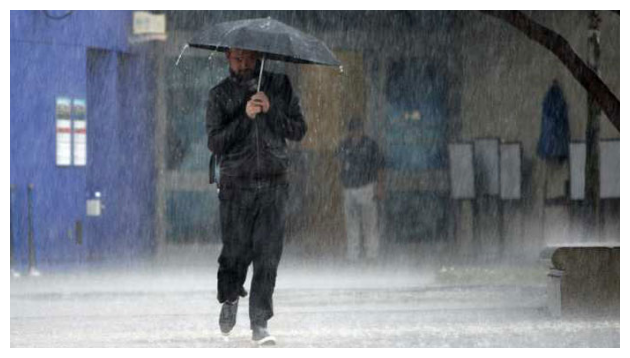



 ############################## Average colors ############################## 




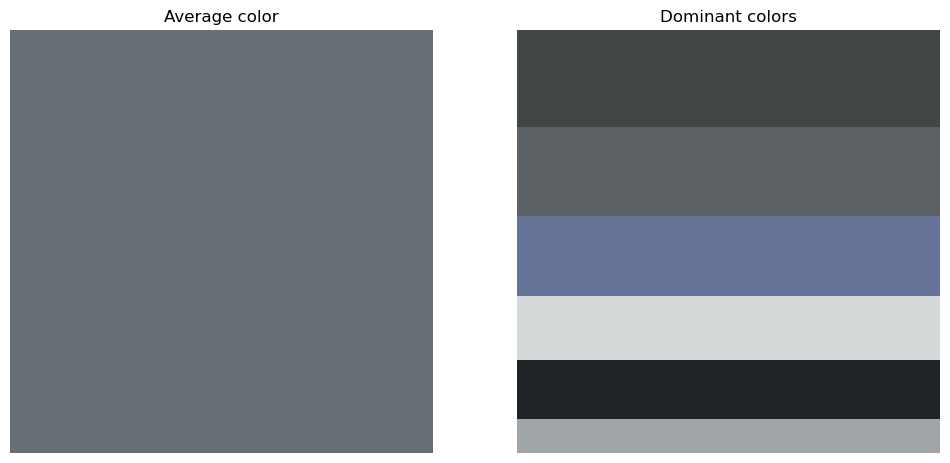



 ############################## Histograms ############################## 




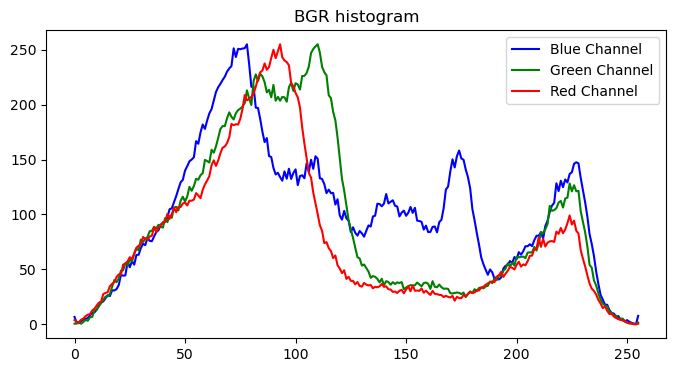

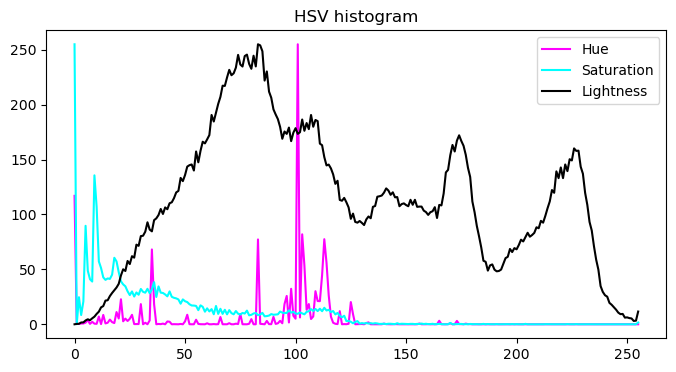



 ############################## DoG ############################## 




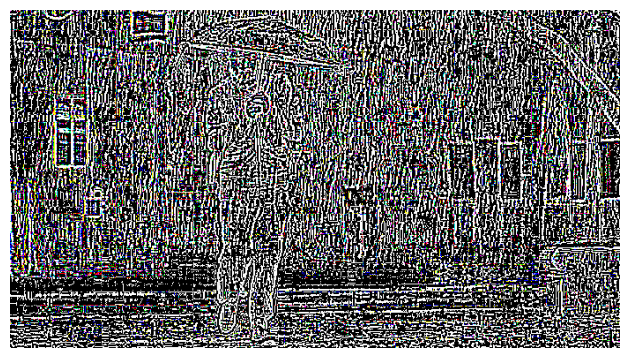



 ############################## Histograms ############################## 




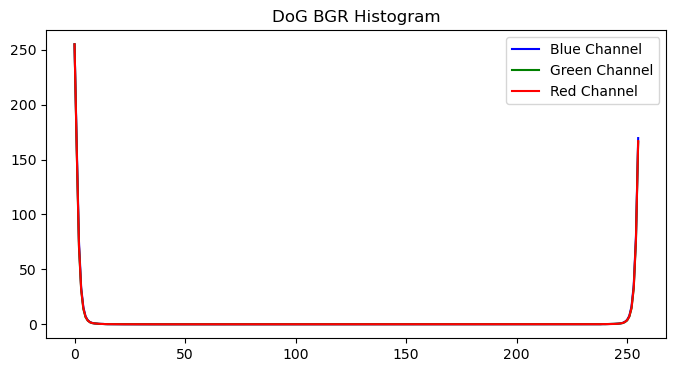

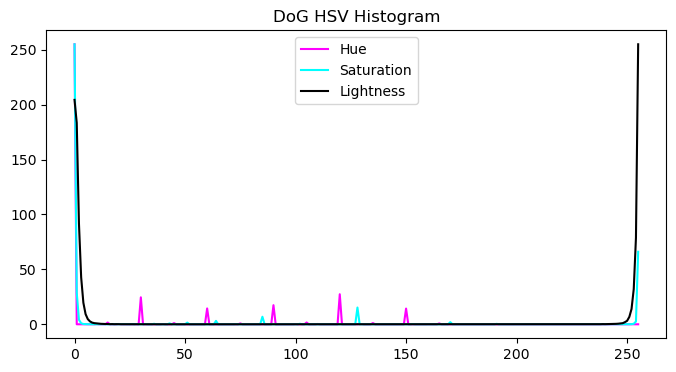



 ############################## Features size ############################## 


	Picture final features shape: (1562,)


 ###########################################################################


In [12]:
# Randomly choose an image for each weather condition from the "test" dataset
# store the pictures in a dictionary
test_pictures={}

weather_conditions=["cloudy","rain","shine","sunrise"]
for weather in weather_conditions:
    while True:
        image=cv.imread(random.choice(get_imagePaths_byWeather(datasetPath,"test", weather)))
        if image is not None:
            test_pictures[weather]=image
            break

# Test the function's outputs and visualize it for one test picture
test_picture_sunrise=test_pictures["rain"]

print("\n\n","#"*30,"Test Picture","#"*30,"\n\n")
show_img(test_picture_sunrise)

# Display average colors and dominant color palette for the test picture
print("\n\n","#"*30,"Average colors","#"*30,"\n\n")
average, palette, counts = get_averageAndDominantColors(test_picture_sunrise)
display_averageAndDominantColors(average, palette, counts)

# Display histograms for the test picture
print("\n\n","#"*30,"Histograms","#"*30,"\n\n")
b,g,r=calculate_picture_histograms(test_picture_sunrise)
display_picture_histogram(b,g,r)

h,s,v=calculate_HSV_histograms(test_picture_sunrise)
display_HSV_histogram(h,s,v)


# Display Difference of Gaussian (DoG) image for the test picture
print("\n\n","#"*30,"DoG","#"*30,"\n\n")
DoG=Difference_Of_Gaussian(test_picture_sunrise)
show_img(DoG)

# Display histograms for the DoG image
print("\n\n","#"*30,"Histograms","#"*30,"\n\n")

b_dog,g_dog,r_dog=calculate_picture_histograms(DoG)
display_picture_histogram(b_dog,g_dog,r_dog,title="DoG BGR Histogram")


h_dog,s_dog,v_dog=calculate_HSV_histograms(DoG)
display_HSV_histogram(h_dog,s_dog,v_dog,title="DoG HSV Histogram")

print("\n\n","#"*30,"Features size","#"*30,"\n")
picture_features=get_picture_color_features(test_picture_sunrise)
print("\n\tPicture final features shape:",picture_features.shape)


print("\n\n","#"*75)

---
# 3. Training and Testing dataset creation

## 3.1 Dataset creation function

In [13]:
def create_inputOutput_dataset(datasetPath, number_of_features,
                               datasetType="train",
                               weather_conditions=["cloudy","rain","shine","sunrise"]):
    """
    Create a dataset for the machine learning algorithm, using the features from the pictures.

    :param datasetPath: The path to the dataset directory.
    :param number_of_features: The number of features per picture to use in the dataset.
    :param datasetType: The type of dataset, "train" or "test".
    :param weather_conditions: The weather conditions to consider (can be used to train on 
                               single weather condition, or a limited select number)

    :return: A tuple containing the feature matrix X and the label vector Y.
    """
    # Start timing the dataset creation for performance evaluation
    start_time = time.time()

    # Initialize empty arrays for features (X) and labels (Y)
    X = np.array([]).reshape(0, number_of_features)
    Y = []

    print(f"\n\nWorking in path:{datasetPath}{datasetType}...\n")
    print(f"Starting construction of {datasetType}ing dataset...")

    # Loop through each weather condition
    for weather in weather_conditions:
        matching_files = [os.path.join(root, file) for root, dirs, files in os.walk(datasetPath+datasetType)
                         for file in files if weather in file]
        print(f"Extracting {weather} pictures data...")

        for file in matching_files:
            picture=cv.imread(file)
    
            if picture is not None:
                # Extract color features for the picture
                picture_features=get_picture_color_features(picture)

                # Append the features to X and the weather condition to Y
                X = np.vstack((X, picture_features))
                Y .append(weather)


    Y  = np.array(Y) # convert Y to numpy array 

    #end timer and display information
    end_time = time.time()
    print("\nExtraction and creation of",str(datasetType)+"ing",
          "dataset completed!\nExecution time:",(np.round((end_time - start_time),decimals=3)),"seconds.\n")
    
    print("X "+str(datasetType), "shape:",X.shape,"\tY "+str(datasetType), "shape:",Y.shape)
    print("\n","#"*100,"\n")
    
    return X,Y



## 3.2 Dataset creation

In [14]:
# Determine the number of features inserted in the get_picture_color_features based on a test picture
number_of_features=len(get_picture_color_features(test_pictures["sunrise"]))

# Create the training and testing datasets
x_train, y_train=create_inputOutput_dataset(datasetPath, 
                                            datasetType="train",
                                            number_of_features=number_of_features)

x_test, y_test=create_inputOutput_dataset(datasetPath, 
                                          datasetType="test",
                                          number_of_features=number_of_features)



Working in path:C:\Uni\ComputerVision\Final Project\Consegna\MWD/train...

Starting construction of training dataset...
Extracting cloudy pictures data...
Extracting rain pictures data...
Extracting shine pictures data...
Extracting sunrise pictures data...

Extraction and creation of training dataset completed!
Execution time: 53.75 seconds.

X train shape: (845, 1562) 	Y train shape: (845,)

 #################################################################################################### 



Working in path:C:\Uni\ComputerVision\Final Project\Consegna\MWD/test...

Starting construction of testing dataset...
Extracting cloudy pictures data...
Extracting rain pictures data...
Extracting shine pictures data...
Extracting sunrise pictures data...

Extraction and creation of testing dataset completed!
Execution time: 14.03 seconds.

X test shape: (278, 1562) 	Y test shape: (278,)

 #################################################################################################### 


## 3.2 Reducing number of features with new or pre-fitted PCA

In [15]:
# Number of principal components to retain after PCA transformation
nr_components_PCA=200

# PCA
if use_pre_storedSVCPCA==0:
    pca = PCA(n_components=nr_components_PCA)

    #Fit the PCA model on the training data
    pca.fit(x_train)
else:
    #use the fallback, pre-saved to file, already fitted PCA
    pca = joblib.load(os.path.abspath(notebookName)[0:-len(notebookName)]+'pca_weatherClassification.pkl')


#transform training and test data with PCA
x_train=pca.transform(x_train)
x_test=pca.transform(x_test)

print("\nPCA transformation completed:")
print("Number of features reduced from",number_of_features,"to",nr_components_PCA,".")


PCA transformation completed:
Number of features reduced from 1562 to 200 .


---


# 4. SVM Training and assessing the model's accuracy 

## 4.1 Finding best SVM parameters and fitting model / Loading pre-stored model

In [16]:
if use_pre_storedSVCPCA==0:
    # test parameters for the GridSearchCV
    parameters={'C':[0.01, 0.1,1,10,100], 
                'gamma':[0.001,0.1,1], 
                'kernel':['linear','rbf','poly']} 
    
    #testing with differnt parameters and kernels to find the best one
    svc=SVC()
    model=GridSearchCV(svc,parameters, n_jobs=-1)#with parallel computing
    
    #fitting and printing paramters
    model.fit(x_train, y_train)
else:
    #use the fallback, pre-saved to file, already fitted svc
    model = joblib.load(os.path.abspath(notebookName)[0:-len(notebookName)]+'svc_weatherClassification.pkl')


print("# Best parameters:\nC:\t ",model.best_params_['C'],
      "\nGamma:\t ",model.best_params_['gamma'],
      "\nKernel:\t ",model.best_params_['kernel'])

training_accuracy, test_accuracy=model.score(x_train, y_train), model.score(x_test,y_test)
training_error, test_error =  1-training_accuracy, 1-test_accuracy

print("Training score:",np.round((training_accuracy*100),decimals=2),"%\t Test score:",np.round((test_accuracy*100),decimals=2),"%")


# Best parameters:
C:	  100 
Gamma:	  0.001 
Kernel:	  rbf
Training score: 100.0 %	 Test score: 94.6 %


## 4.2 Getting and plotting confusion matrixes

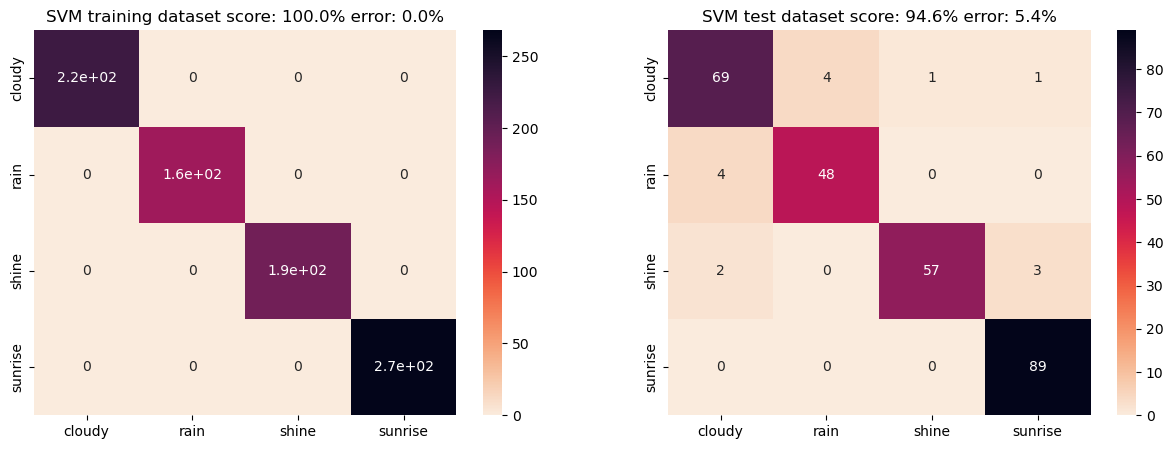

In [17]:
# Generate predictions on training and testing datasets
svm_train_prediction=model.predict(x_train)
svm_test_prediction=model.predict(x_test)

# Calculate the confusion matrices for training and testing predictions
svm_CM_train, svm_CM_test=confusion_matrix(y_train, svm_train_prediction),confusion_matrix(y_test, svm_test_prediction)

labels = np.unique(weather_conditions)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the confusion matrix for training dataset
sn.heatmap(svm_CM_train, annot=True, ax=axes[0], cmap='rocket_r', vmax=np.max(svm_CM_train))
axes[0].set_xticklabels(labels)
axes[0].set_yticklabels(labels)
axes[0].set_title(f"SVM training dataset score: {np.round((training_accuracy*100),decimals=2)}% error: {np.round((training_error*100),decimals=2)}%")

# Plot the confusion matrix for testing dataset
sn.heatmap(svm_CM_test, annot=True, ax=axes[1], cmap='rocket_r', vmax=np.max(svm_CM_test))
axes[1].set_xticklabels(labels )
axes[1].set_yticklabels(labels)
axes[1].set_title(f"SVM test dataset score: {np.round((test_accuracy*100),decimals=2)}% error: {np.round((test_error*100),decimals=2)}%")

# Also save a the plot as a picture in the notebook directory
#plt.savefig("confusionMatrixAndScores.png",bbox_inches='tight')
plt.show()

## 4.3 Displaying prediction examples

### Just re-run the following block to see new prediction examples

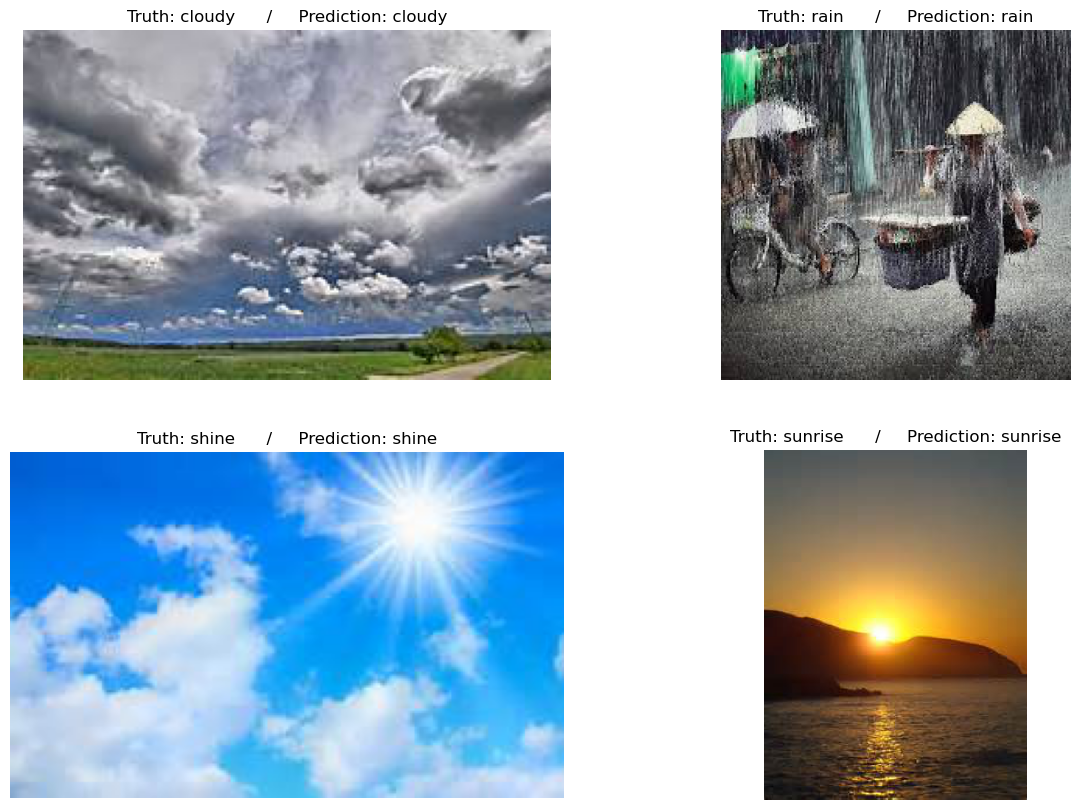

In [18]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

weather_conditions = ["cloudy", "rain", "shine", "sunrise"]
test_pictures = {}

for i, weather in enumerate(weather_conditions):
    while True:
        picture = cv.imread(random.choice(get_imagePaths_byWeather(datasetPath, "test", weather)))
        if picture is not None:

            # Calculate prediction
            picture_features = get_picture_color_features(picture)
            picture_features = pca.transform([picture_features])
            picture_features = picture_features.reshape(1, -1)
            prediction = model.predict(picture_features)
            
            # Display the image and prediction in the corresponding subplot
            row = i // 2
            col = i % 2
            axes[row, col].imshow(cv.cvtColor(picture, cv.COLOR_BGR2RGB))
            axes[row, col].set_title(f"Truth: {weather}      /     Prediction: {prediction[0]}")
            axes[row, col].axis('off')
            break

# Adjust spacing and display the plot
plt.subplots_adjust(wspace=0.1, hspace=0.2)

#plt.savefig("random_output_example.png",bbox_inches='tight')
plt.show()

## 4.4 Show misclassified   prediction examples

Shows only the first found misclassified  pictures, if any


############################################################ 

Looking for missclassified "cloudy" pictures...
	 Found one!
Looking for missclassified "rain" pictures...
	 Found one!
Looking for missclassified "shine" pictures...
	 Found one!
Looking for missclassified "sunrise" pictures...
	I did not found any "sunrise" misclassified pictures!

############################################################ 



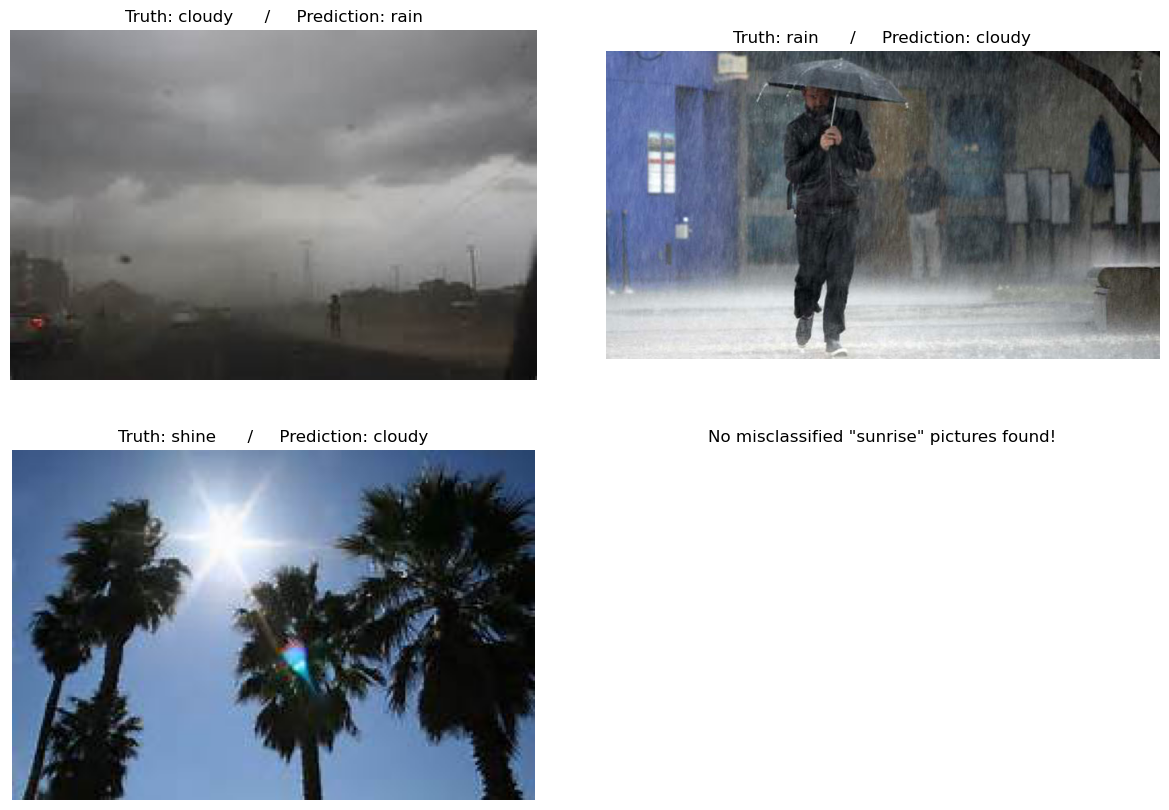

In [19]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

weather_conditions = ["cloudy", "rain", "shine", "sunrise"]
test_pictures = {}


print("\n"+"#"*60,"\n")
for weather in weather_conditions:
    matching_files = [os.path.join(root, file) for root, dirs, files in os.walk(datasetPath+"test/"+weather)
                     for file in files if weather in file]
    print(f"Looking for missclassified \"{weather}\" pictures...")

    foundMisclassifiedPicture=False
    for file in matching_files:
        picture = cv.imread(file)
        
        if picture is not None:
            picture_features = get_picture_color_features(picture)
            picture_features = pca.transform([picture_features])
            picture_features = picture_features.reshape(1, -1)
            prediction=model.predict(picture_features)
            if prediction!=weather:
                foundMisclassifiedPicture=True
                row = weather_conditions.index(weather) // 2
                col = weather_conditions.index(weather)  % 2
                axes[row, col].imshow(cv.cvtColor(picture, cv.COLOR_BGR2RGB))
                axes[row, col].set_title(f"Truth: {weather}      /     Prediction: {prediction[0]}")
                axes[row, col].axis('off')
                break
                
    if foundMisclassifiedPicture:
        print(f"\t Found one!")
    else:
        print(f"\tI did not found any \"{weather}\" misclassified pictures!")
        row = weather_conditions.index(weather) // 2
        col = weather_conditions.index(weather)  % 2
        axes[row, col].set_title(f"No misclassified \"{weather}\" pictures found!")
        axes[row, col].axis('off')

print("\n"+"#"*60,"\n")

# Adjust spacing and display the plot
plt.subplots_adjust(wspace=0.1, hspace=0.2)
#plt.savefig("missclassification_output_example.png",bbox_inches='tight')
plt.show()